In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import pickle as pk
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.chdir("/afs/csail.mit.edu/u/s/samsl/Work/Adapting_PLM_DTI")

In [8]:
database_root = "/afs/csail.mit.edu/u/s/samsl/Work/databases"

# Load Side Effects DB

In [55]:
side_effect_db = pd.read_csv(f"{database_root}/Decagon/bio-decagon-mono.csv")
side_effect_db['STITCH'] = side_effect_db['STITCH'].apply(update_cid_name)

In [56]:
def update_cid_name(x):
    x = list(x)
    x[3] = 's'
    return ''.join(x)

In [57]:
uniq_drugs = side_effect_db['STITCH'].unique()
print(len(uniq_drugs))

639


In [37]:
with open(f'{database_root}/Decagon/uniq_drugs.txt','w+') as f:
    for d in uniq_drugs:
        f.write(f"{d}\n")

In [58]:
stitch_db = pd.read_csv(f"{database_root}/Decagon/stitch_chemicals.tsv",sep="\t",header=None)
stitch_db.columns = ['STITCH','Common Name', 'Weight', 'SMILE']

In [68]:
merge_db = pd.merge(side_effect_db, stitch_db, left_on='STITCH', right_on='STITCH', how='inner')
smile_db = merge_db[['STITCH','SMILE']].drop_duplicates()

In [121]:
n_side_effects = merge_db.groupby('STITCH')['Individual Side Effect'].count()

In [247]:
merge_db

,STITCH,Individual Side Effect,Side Effect Name,Common Name,Weight,SMILE
0,CIDs03062316,C1096328,central nervous system mass,dasatinib,488.00554,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...
1,CIDs03062316,C0162830,Photosensitivity reaction,dasatinib,488.00554,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...
2,CIDs03062316,C1611725,leukaemic infiltration brain,dasatinib,488.00554,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...
3,CIDs03062316,C0541767,platelet adhesiveness abnormal,dasatinib,488.00554,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...
4,CIDs03062316,C0242973,Ventricular dysfunction,dasatinib,488.00554,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=NC(=NC(...
...,...,...,...,...,...,...
165237,CIDs05282226,C1096278,anterior chamber inflammation,travoprost,500.54771,CC(C)OC(=O)CCCC=CCC1C(CC(C1C=CC(COC2=CC=CC(=C2...
165238,CIDs05282226,C0272412,splenic abscess,travoprost,500.54771,CC(C)OC(=O)CCCC=CCC1C(CC(C1C=CC(COC2=CC=CC(=C2...
165239,CIDs05282226,C0860013,hepatitis b antibody positive,travoprost,500.54771,CC(C)OC(=O)CCCC=CCC1C(CC(C1C=CC(COC2=CC=CC(=C2...
165240,CIDs05282226,C0853225,international normalised ratio increased,travoprost,500.54771,CC(C)OC(=O)CCCC=CCC1C(CC(C1C=CC(COC2=CC=CC(=C2...


# Load Proteins

In [214]:
# from Bio import SeqIO

# human_seq_db = {i.name: str(i.seq) for i in list(SeqIO.parse(f"{database_root}/STRING/homo.sapiens/50_800_SEQUENCES_NONRED.fasta","fasta"))}

In [225]:
human_seq_db = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_download.tsv',sep='\t')
human_seq_db = human_seq_db[~human_seq_db['Sequence'].isna()]
human_seq_db = {r.Entry: r.Sequence for _, r in human_seq_db.iterrows()}

In [216]:
almen_major = pk.load(open(f'nbdata/surfaceome_almen_major.pk','rb'))
almen_minor = pk.load(open(f'nbdata/surfaceome_almen_minor.pk','rb'))

# Load Model and Generate Embeddings

In [217]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

In [218]:
# Load model
device = torch.device(6)
drug_f = MorganFeaturizer().cuda(device)
target_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(drug_f.shape, target_f.shape, 1024)
model.load_state_dict(torch.load("best_models/reverse_margin_best_model.pt"))
model = model.to(device)

In [226]:
drug_projections = {} 
target_projections = {}

with torch.set_grad_enabled(False):
    for _, r in tqdm(smile_db.iterrows(),total=len(smile_db)):
        drug_projections[r['STITCH']] = model.drug_projector(drug_f(r['SMILE']).unsqueeze(0)).detach().cpu().numpy()

    for k, v in tqdm(human_seq_db.items(),total=len(human_seq_db)):
        target_projections[k] = model.target_projector(target_f(v).unsqueeze(0)).detach().cpu().numpy()

  0%|          | 0/604 [00:00<?, ?it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

In [227]:
pk.dump(drug_projections,open(f'nbdata/pb_morgan_decagon_embeddings_20220829.pk','wb'))
pk.dump(target_projections,open(f'nbdata/pb_morgan_surfaceome_embeddings_20220829.pk','wb'))
# drug_projections = pk.load(open(f'nbdata/pb_morgan_decagon_embeddings_20220829.pk','rb'))
# target_projections = pk.load(open(f'nbdata/pb_morgan_surfaceome_embeddings_20220829.pk','rb'))

In [228]:
drug_proj_np = np.stack([i.squeeze() for i in drug_projections.values()])
target_proj_np = np.stack([i.squeeze() for i in target_projections.values()])
all_proj_np = np.concatenate([drug_proj_np, target_proj_np])

In [229]:
n_drugs = drug_proj_np.shape[0]
n_targets = target_proj_np.shape[0]

# Pairwise Computations

In [231]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(metric="cosine").fit_transform(all_proj_np)
# pk.dump(embed_tsne,open(f'nbdata/pb_morgan_decagonxsurfaceome_tsne_20220830.pk','wb'))
# embed_tsne = pk.load(open(f'nbdata/pb_morgan_decagonxsurfaceome_tsne_20220830.pk','rb'))

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [238]:
from torch import sigmoid
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine

def sig_cosine_sim(x,y):
    cosine_similarity = CosineSimilarity(dim=0)
    return sigmoid(cosine_similarity(torch.from_numpy(x),torch.from_numpy(y))).numpy().item()

def cosine_sim(x,y):
    return cosine(x,y)

In [273]:
# dist = np.zeros((n_drugs, n_targets))

# for i, dp in tqdm(enumerate(drug_proj_np), total=n_drugs):
#     for j, pp in enumerate(target_proj_np):
#         dist[i,j] = cosine_sim(dp,pp)
# pk.dump(dist,open(f'nbdata/pb_morgan_decagonxsurfaceome_distances_20220830.pk','wb'))
dist = pk.load(open(f'nbdata/pb_morgan_decagonxsurfaceome_distances_20220830.pk','rb'))

# Visualization

In [274]:
from scipy.stats import pearsonr

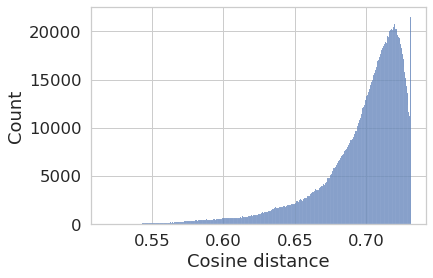

In [276]:
sns.histplot(dist.ravel())
plt.xlabel("Cosine distance")
plt.ylabel("Count")
plt.show()

In [283]:
n_close = (dist < 0.6).sum(axis=1)

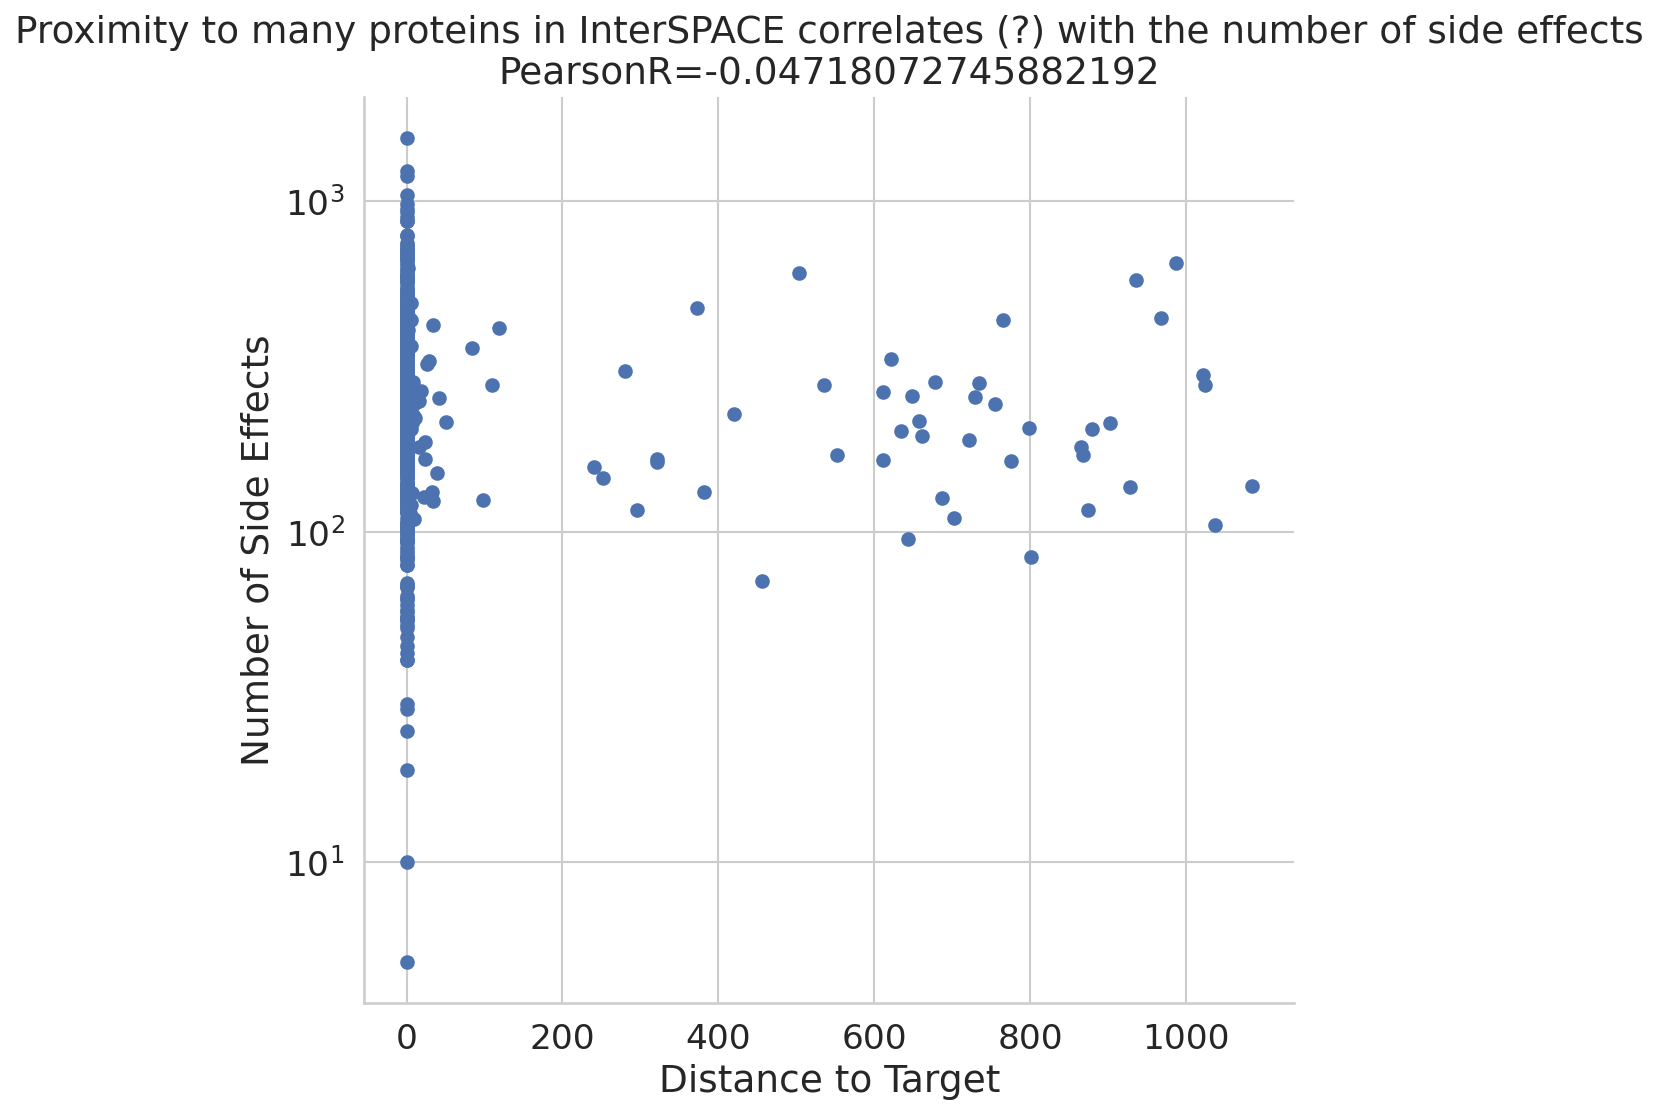

In [284]:
sns.set(style='whitegrid',font_scale=1.5)
plt.figure(figsize=(8, 8), dpi=150)

# dist_measure = np.min(dist,axis=1)
dist_measure = n_close

stat,pval = pearsonr(dist_measure, n_side_effects.values)

plt.scatter(dist_measure, n_side_effects.values)
plt.xlabel('Distance to Target')
plt.ylabel('Number of Side Effects')
plt.yscale('log')
plt.title(f'Proximity to many proteins in InterSPACE correlates (?) with the number of side effects\nPearsonR={stat}')
sns.despine()
plt.show()

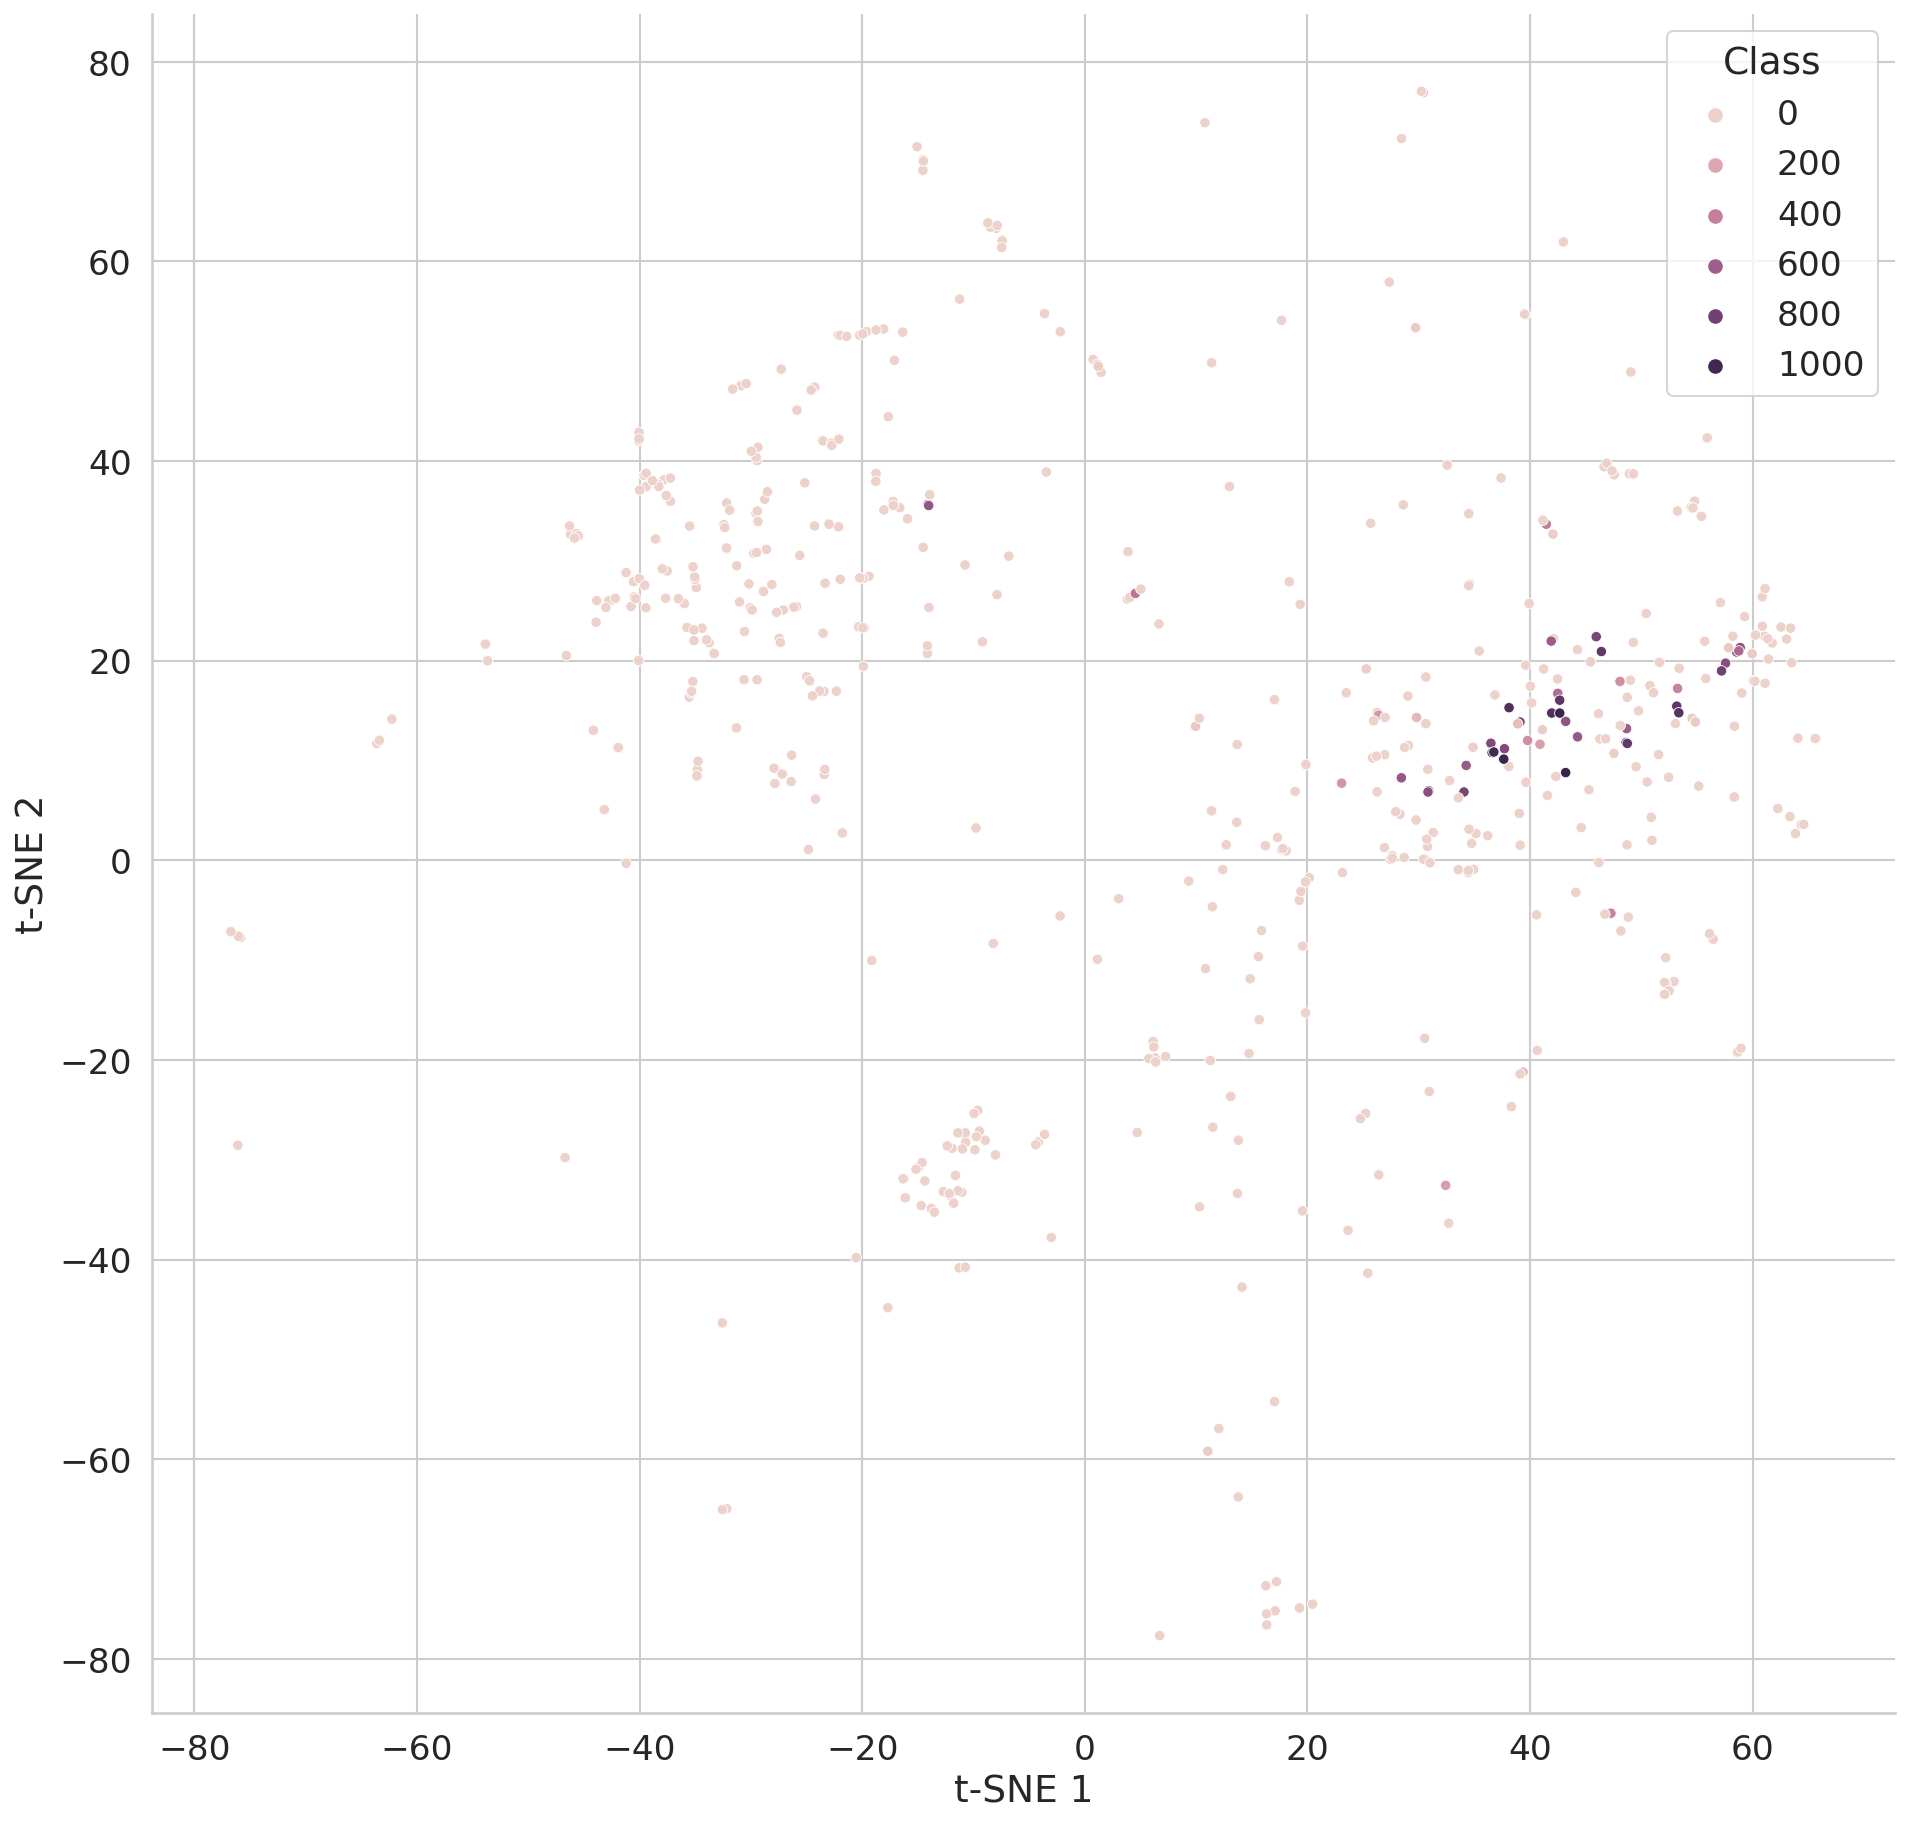

In [285]:
# pal = sns.color_palette("tab10", 2) 
sns.set(style='whitegrid',font_scale=1.5)
plt.figure(figsize=(15, 15), dpi=150)


# style = ['Drug'] * n_drugs + ['Target'] * n_targets
# style = np.concatenate([n_side_effects.values, np.array([0] * n_targets)])
style = dist_measure


plot_df = pd.DataFrame({
    't-SNE 1': embed_tsne[:n_drugs,0],
    't-SNE 2': embed_tsne[:n_drugs,1],
    'Class': style
})

sns.scatterplot(
    data = plot_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = 'Class',
    s=25,
    alpha=1,
   )
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
# plt.title('Projection of Surfaceome Proteins into DTI Space')
sns.despine()
plt.show()